### LightGBM tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl # colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime as dt
import pickle

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.1
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,classification_report
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [4]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_convergence

In [5]:
import warnings

In [6]:
#Load data

In [7]:
df = pd.read_csv("./data/work_final_4modeling.csv",index_col='ID',low_memory=False)

cols_to_rm = ['VAR_0181', 'VAR_0512', 'VAR_0201', 'VAR_0182', 'VAR_0529', 'VAR_0228', 'VAR_0238', 'VAR_0210'
             ,'VAR_0211', 'VAR_0357', 'VAR_0013', 'VAR_1036']

X = df.drop(cols_to_rm,axis=1)

X.shape

(145231, 1880)

In [8]:
y = pd.read_csv("./data/work_target.csv",index_col='ID',low_memory=False)
y.shape

(145231, 1)

### 1. Reduced dataset <a id='1'></a>

In [9]:
with open('./data/cols_LR_c0_01.pkl', 'rb') as f:    
    cols_reduced = pickle.load(f)
    
X_reduced = X[cols_reduced]
X_reduced.shape

(145231, 359)

In [10]:
#Hypertuning

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X_reduced,y.values.ravel(),test_size=0.5,random_state=123)

In [12]:
from_file = True

t1 = dt.now()

opt = 0

if from_file:
    with open('./data/lgbm_reduced_bayes.pkl', 'rb') as f: 
        opt = pickle.load(f)
else:

    lgbm = LGBMClassifier(random_state=123,n_jobs=-1)

    grid = {'learning_rate' : Real(0.002,0.02),
            'n_estimators' : Integer(100, 15000,prior='log-uniform'),
#            'num_leaves': Integer(16, 65536,prior='log-uniform'), #2^16
            'num_leaves': Integer(16, 8192,prior='log-uniform'), #2^13
            'colsample_bytree': Real(0.001,1),
            'reg_lambda' : Real(0,1000),
            'reg_alpha' :  Real(0,1000),
            'min_child_samples' : Integer(5,2000)
            }


    opt = BayesSearchCV(lgbm,search_spaces=grid,scoring='roc_auc',return_train_score=True
                        ,verbose=4,n_iter=250,cv=2)

    opt.fit(X_train, y_train)
    
    with open('./data/lgbm_reduced_bayes.pkl', 'wb') as f:
        pickle.dump(opt, f)
    
    
print('val. score =',opt.best_score_)
print('Best parameters =',opt.best_params_)

print(round((dt.now()-t1).total_seconds()/60,1),'min elapsed')
# 2923.7 min elapsed, 48.7 h = 2d

val. score = 0.7790634111700387
Best parameters = OrderedDict([('colsample_bytree', 0.386298114951441), ('learning_rate', 0.02), ('min_child_samples', 5), ('n_estimators', 8002), ('num_leaves', 3982), ('reg_alpha', 0.0), ('reg_lambda', 0.0)])
0.1 min elapsed


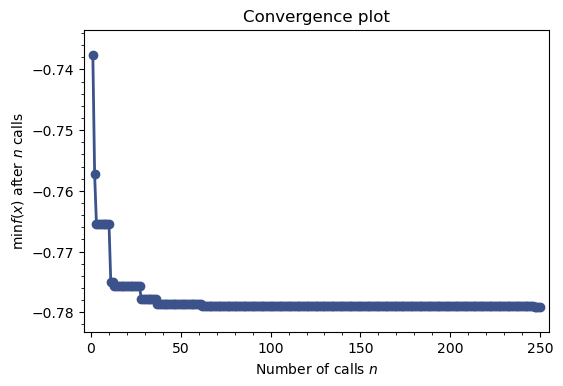

In [13]:
ax = plot_convergence(opt.optimizer_results_[0]);

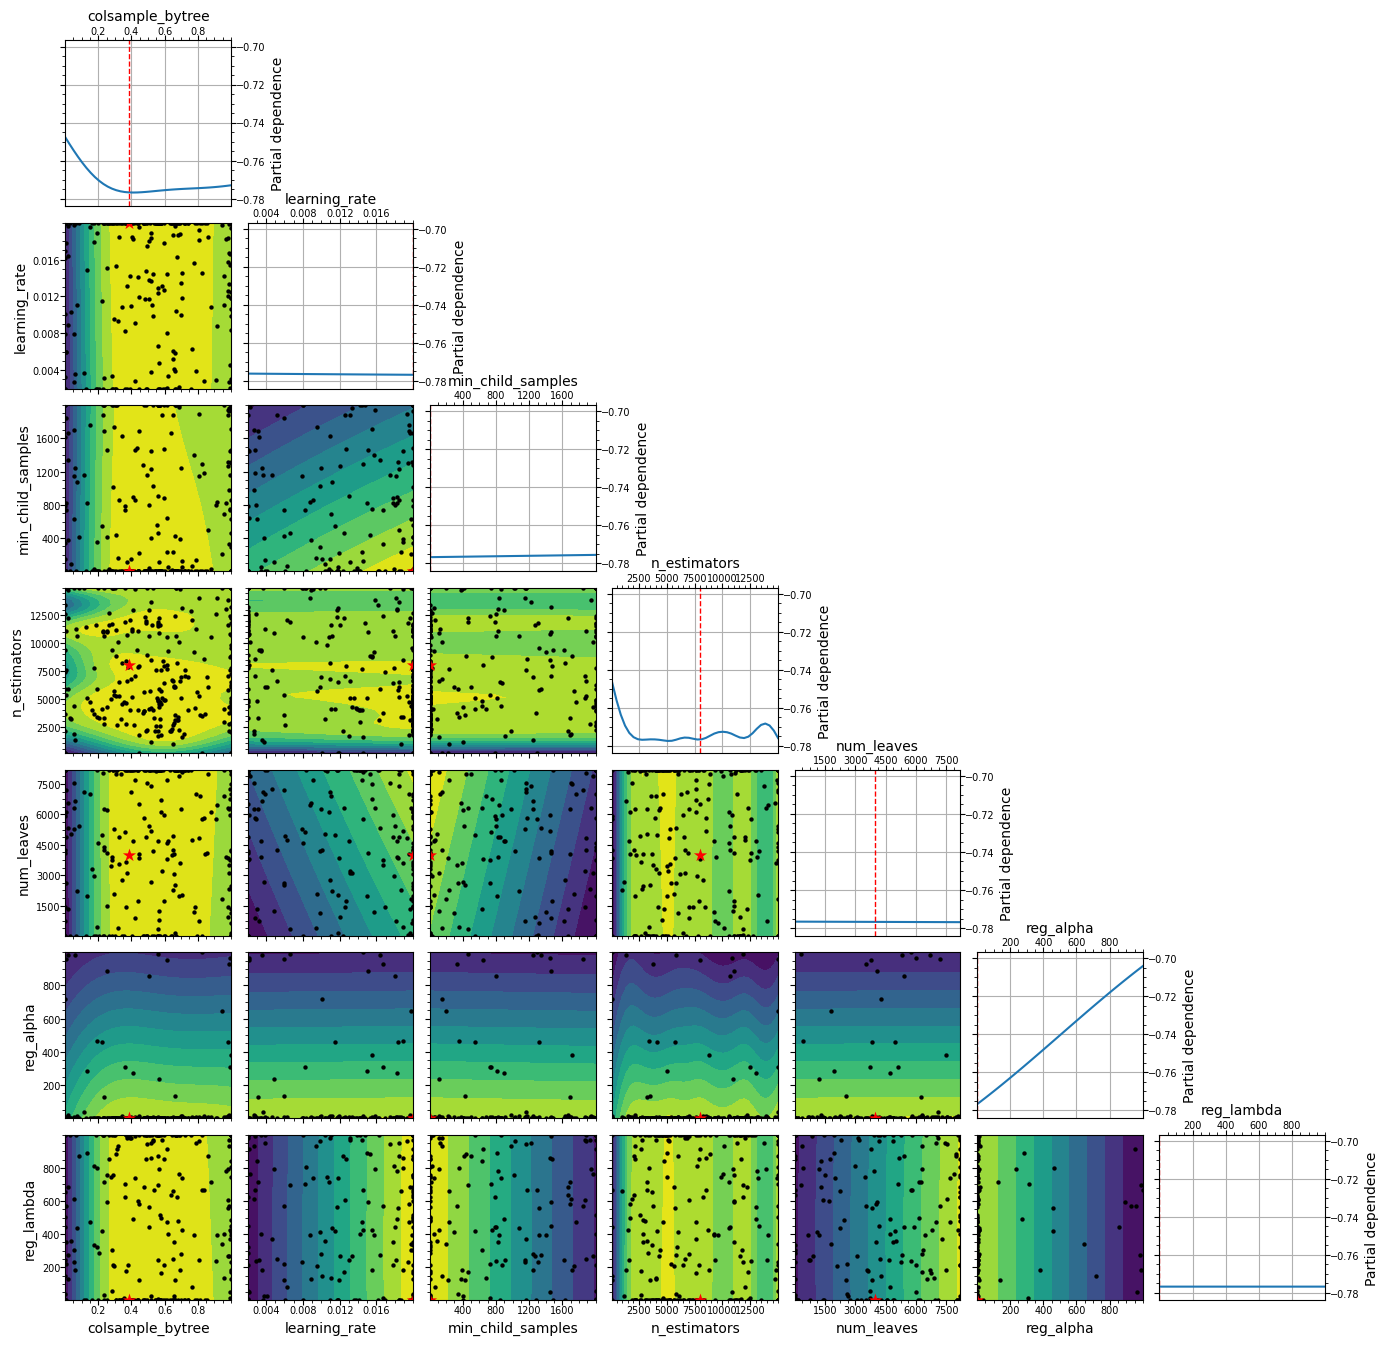

In [14]:
ax = plot_objective(opt.optimizer_results_[0],sample_source='result')

for ai in ax.ravel():
    ai.tick_params(axis='both', which='major', labelsize=7,rotation=0,pad=0)

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_reduced,y.values.ravel(),test_size=0.25,random_state=123)

In [16]:
#Rerun on more data to get the roc-auc score

In [17]:
lgb_reduced_final = LGBMClassifier(learning_rate=0.02
                                   ,n_estimators=8002
                                   ,num_leaves=3982
                                   ,colsample_bytree=0.386298114951441
                                   ,min_child_samples=5
                                   ,random_state=123,n_jobs=-1)
#lgb_reduced_final.get_params()

In [18]:
from_file = True

t1 = dt.now()

if from_file:
    with open('./data/lgb_reduced_final.pkl', 'rb') as f: 
        lgb_reduced_final = pickle.load(f)
else:
    
    lgb_reduced_final.fit(X_train,y_train)
    
    with open('./data/lgb_reduced_final.pkl', 'wb') as f:
        pickle.dump(lgb_reduced_final, f)
       
t2 = dt.now()
print(round((t2-t1).total_seconds()/60,1),'min elapsed')
# 16.5 min elapsed

0.1 min elapsed


roc_auc (train)=  1.0
roc_auc (test) =  0.79486 

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     27893
           1       0.70      0.28      0.40      8415

    accuracy                           0.81     36308
   macro avg       0.76      0.62      0.64     36308
weighted avg       0.79      0.81      0.77     36308



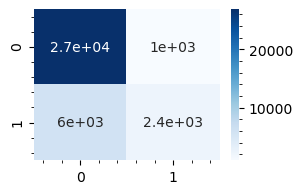

In [19]:
y_pred_proba_tr = lgb_reduced_final.predict_proba(X_train)[:,1]
y_pred_proba    = lgb_reduced_final.predict_proba(X_test)[:,1]
y_pred          = lgb_reduced_final.predict(X_test)

print('roc_auc (train)= ',round(roc_auc_score(y_train,y_pred_proba_tr,average = "weighted"),5))
print('roc_auc (test) = ',round(roc_auc_score(y_test,y_pred_proba,average = "weighted"),5),'\n')

print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(cm,annot=True,cmap='Blues',ax=ax);

### 2. Full dataset  <a id='2'></a>

In [32]:
X.shape

(145231, 1880)

In [20]:
#Hypertuning

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y.values.ravel(),test_size=0.5,random_state=123)

In [22]:
from_file = True

t1 = dt.now()

opt = 0

if from_file:
    with open('./data/lgbm_full_bayes.pkl', 'rb') as f: 
        opt = pickle.load(f)
else:

    lgbm = LGBMClassifier(random_state=123,n_jobs=7)

    grid = {'learning_rate' : Real(0.005,0.03),
            'n_estimators' : Integer(100, 15000,prior='log-uniform'),
            'num_leaves': Integer(16, 8192,prior='log-uniform'), #2^13
            'colsample_bytree': Real(0.001,1),
            'min_child_samples' : Integer(5,1000)
            }

    opt = BayesSearchCV(lgbm,search_spaces=grid,scoring='roc_auc',return_train_score=True
                        ,verbose=2,cv=2,n_iter=100)

    opt.fit(X_train, y_train)
    
    with open('./data/lgbm_full_bayes.pkl', 'wb') as f:
        pickle.dump(opt, f)
    
    
print('val. score =',opt.best_score_)
print('Best parameters =',opt.best_params_)

print(round((dt.now()-t1).total_seconds()/60,1),'min elapsed')
# 7046.9 min elapsed, 117 h = 4.9 days

val. score = 0.7811702126220353
Best parameters = OrderedDict([('colsample_bytree', 0.12931280758267424), ('learning_rate', 0.005100292266521394), ('min_child_samples', 5), ('n_estimators', 10396), ('num_leaves', 304)])
0.1 min elapsed


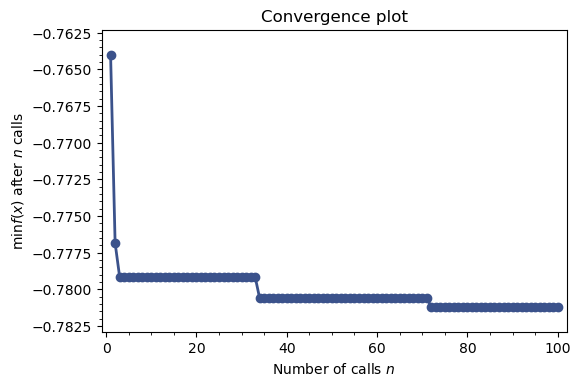

In [23]:
ax = plot_convergence(opt.optimizer_results_[0]);

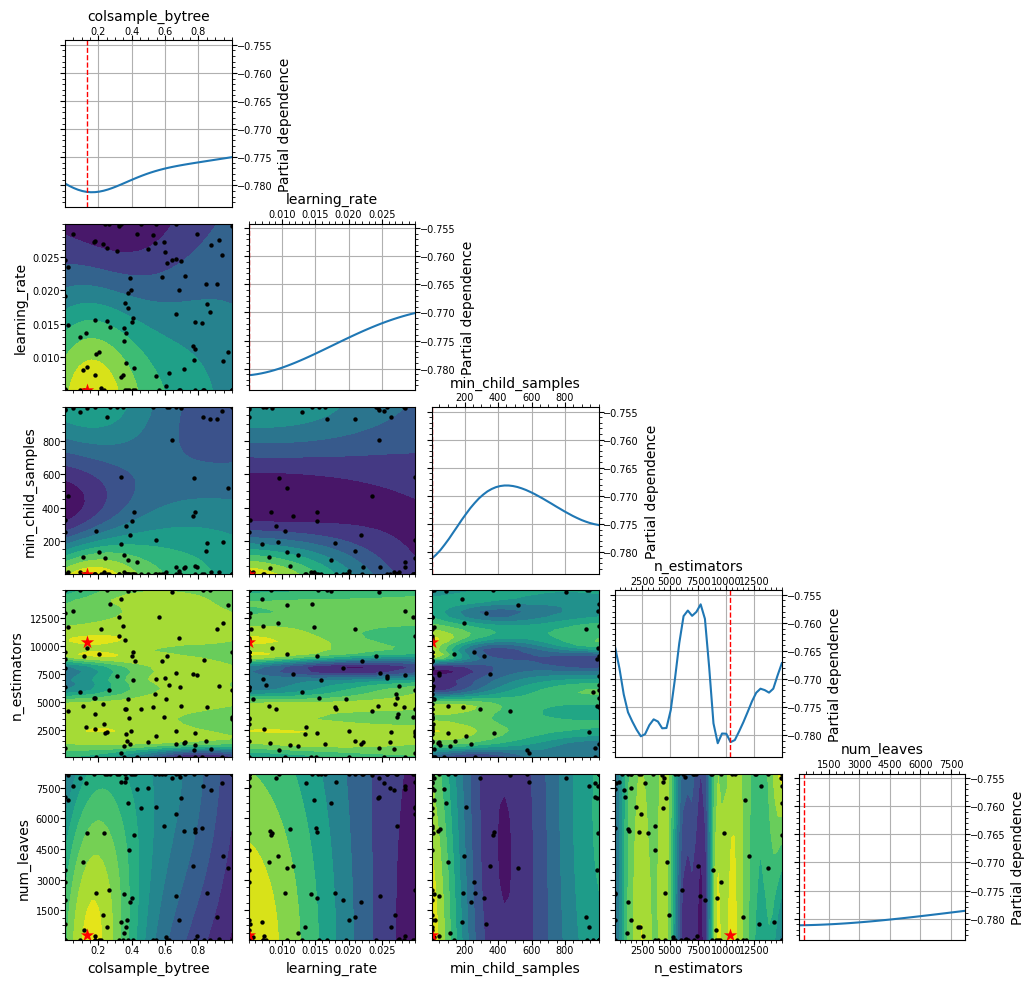

In [30]:
ax = plot_objective(opt.optimizer_results_[0],sample_source='result')

for ai in ax.ravel():
    ai.tick_params(axis='both', which='major', labelsize=7,rotation=0,pad=0)

In [31]:
for i,fmin in zip(opt.optimizer_results_[0]['x_iters'],opt.optimizer_results_[0]['func_vals']):
    if i[3] > 6500 and i[3] < 8500:
        print(i,'-f=',round(-fmin,3))

[0.7655678136215263, 0.011700338112025926, 351, 7524, 3663] -f= 0.773
[0.6643759227385181, 0.024662871315013293, 46, 7650, 2188] -f= 0.778
[0.001, 0.019210800517893162, 5, 8100, 1985] -f= 0.737
[0.7909512081183585, 0.028528439353179932, 46, 7416, 223] -f= 0.776
[0.5442906335825218, 0.007130642661958312, 5, 7123, 16] -f= 0.777
[0.623632934178562, 0.007678589993447508, 1000, 6582, 16] -f= 0.776
[0.6000545090945181, 0.02580288122301568, 5, 7149, 8192] -f= 0.778
[0.4090096541360229, 0.015832463969858233, 5, 7028, 8192] -f= 0.779
[0.31013721076466744, 0.025842846170742347, 1000, 7339, 8192] -f= 0.765


In [33]:
# all f are high (<-0.77) except f= -0.737 fpr colsample_by_tree=0.001.
# colsample_by_tree=0.001 * 1880 = 1.88 ~= 2 features. My mistake in range setting, maybe this is the problem.

In [25]:
#Rerun on more data to get the roc-auc score

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y.values.ravel(),test_size=0.25,random_state=123)

In [27]:
lgb_final5 = LGBMClassifier(learning_rate=0.005100292266521394
                           ,n_estimators=10396
                           ,num_leaves=304
                           ,colsample_bytree=0.12931280758267424
                           ,min_child_samples=5
                           ,random_state=123,n_jobs=-1)
#lgb_final5.get_params()

In [28]:
#from_file = False
from_file = True

t1 = dt.now()

if from_file:
    with open('./data/lgb_final5.pkl', 'rb') as f: 
        lgb_final5 = pickle.load(f)
else:
    
    lgb_final5.fit(X_train,y_train)
    
    with open('./data/lgb_final5.pkl', 'wb') as f:
        pickle.dump(lgb_final5, f)
       
t2 = dt.now()
print(round((t2-t1).total_seconds()/60,1),'min elapsed')
# 14.5 min elapsed

0.0 min elapsed


roc_auc (train)    =  0.96809
roc_auc (test wei) =  0.79233
roc_auc (test)     =  0.79233 

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     27893
           1       0.68      0.28      0.39      8415

    accuracy                           0.80     36308
   macro avg       0.75      0.62      0.64     36308
weighted avg       0.78      0.80      0.77     36308



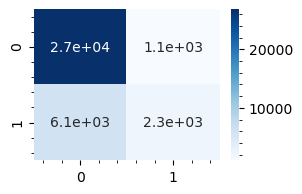

In [29]:
y_pred_proba_tr = lgb_final5.predict_proba(X_train)[:,1]
y_pred_proba    = lgb_final5.predict_proba(X_test)[:,1]
y_pred          = lgb_final5.predict(X_test)

print('roc_auc (train)    = ',round(roc_auc_score(y_train,y_pred_proba_tr,average = "weighted"),5))
print('roc_auc (test wei) = ',round(roc_auc_score(y_test,y_pred_proba,average = "weighted"),5))
print('roc_auc (test)     = ',round(roc_auc_score(y_test,y_pred_proba),5),'\n')

print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(cm,annot=True,cmap='Blues',ax=ax);

And this is worse from the results I got with my very first tuning on full dataset:
    
    lgb_final2 = LGBMClassifier(learning_rate=0.01      # fixed
                           ,n_estimators=3535           # (100,5000)
                           ,num_leaves=700              # (16,700)
                           ,colsample_bytree=0.29       # (0.001,1)
                           ,random_state=123,n_jobs=-1)

roc_auc (test) =  0.79769, which is within the first 40 entries in the private leaderboard on Kaggle.